In [1]:

%pylab inline
from IPython.display import Audio
import librosa
import scipy as sp

figsize(20,6)

import tensorflow as tf
tf.enable_eager_execution()

prefix="osc_rect"
def filepre(nm):
    return "tmp/"+prefix+"_"+nm

Populating the interactive namespace from numpy and matplotlib


In [2]:

def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = max(abs(np.linalg.eig(internalWeights)[0]))
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

pLoop = lambda n,p: p[n%p.size]

In [68]:
def compareMelSpec(seq1, seq2):
    fftSize=2048
    hop=1024  
    melspec = librosa.feature.melspectrogram(y=seq1, sr=sr, n_fft=fftSize,hop_length=hop)
    melspec2 = librosa.feature.melspectrogram(y=seq2, sr=sr, n_fft=fftSize,hop_length=hop)
    return nrmse(melspec.flatten(), melspec2.flatten())
        

In [4]:
#using digital bandlimited oscillators, from https://gist.github.com/endolith/407991 - thanks

In [69]:
def bl_sawtooth(t): # , width=1
    """
    Return a periodic band-limited sawtooth wave with
    period 2*pi which is falling from 0 to 2*pi and rising at
    2*pi (opposite phase relative to a sin)
    Produces the same phase and amplitude as scipy.signal.sawtooth.
    Examples
    --------
    >>> t = linspace(0, 1, num = 1000, endpoint = False)
    >>> f = 5 # Hz
    >>> plot(bl_sawtooth(2 * pi * f * t))
    """
    t = asarray(t)

    if abs((t[-1]-t[-2]) - (t[1]-t[0])) > .0000001:
        raise ValueError("Sampling frequency must be constant")

    if t.dtype.char in ['fFdD']:
        ytype = t.dtype.char
    else:
        ytype = 'd'
    y = zeros(t.shape, ytype)

    # Get sampling frequency from timebase
    fs =  1 / (t[1] - t[0])
    #    fs =  1 / amax(diff(t))

    # Sum all multiple sine waves up to the Nyquist frequency

    # TODO: Maybe choose between these based on number of harmonics?

    # Slower, uses less memory
    for h in range(1, int(fs*pi)+1):
        y += 2 / pi * -sin(h * t) / h

    # Faster, but runs out of memory and dies
#    h = arange(1, int(fs * pi) + 1)
#    phase = outer(t, h)
#    y = 2 / pi * -sin(phase) / h
#    y = sum(y, axis=1)

    return y


def bl_triangle(t):
    """
    Return a periodic band-limited triangle wave with
    period 2*pi which is falling from 0 to pi and rising from
    pi to 2*pi (same phase as a cos)
    Produces the same phase and amplitude as scipy.signal.sawtooth(width=0.5).
    Examples
    --------
    >>> t = linspace(0, 1, num = 1000, endpoint = False)
    >>> f = 5 # Hz
    >>> plot(bl_triangle(2 * pi * f * t))
    """
    t = asarray(t)

    if abs((t[-1]-t[-2]) - (t[1]-t[0])) > .0000001:
        raise ValueError("Sampling frequency must be constant")

    if t.dtype.char in ['fFdD']:
        ytype = t.dtype.char
    else:
        ytype = 'd'
    y = zeros(t.shape, ytype)

    # Get sampling frequency from timebase
    fs =  1 / (t[1] - t[0])

    # Sum all odd multiple sine waves up to the Nyquist frequency

    # Slower, uses less memory
    for h in range(1, int(fs * pi) + 1, 2):
        y += 8 / pi**2 * -cos(h * t) / h**2

    # Faster, but runs out of memory and dies
#    h = arange(1, int(fs * pi) + 1, 2)
#    phase = outer(t, h)
#    y = 8 / pi**2 * -cos(phase) / h**2
#    y = sum(y, axis=1)

    return y


def bl_square(t, duty=0.5):
    """
    Return a periodic band-limited square wave with
    period 2*pi which is +1 from 0 to pi and -1 from
    pi to 2*pi (same phase as a sin)
    Produces the same phase and amplitude as scipy.signal.square.
    Similarly, duty cycle can be set, or varied over time.
    Examples
    --------
    >>> t = linspace(0, 1, num = 10000, endpoint = False)
    >>> f = 5 # Hz
    >>> plot(bl_square(2 * pi * f * t))
    >>> sig = np.sin(2 * np.pi * t)
    >>> pwm = bl_square(2 * np.pi * 30 * t, duty=(sig + 1)/2)
    >>> plt.subplot(2, 1, 1)
    >>> plt.plot(t, sig)
    >>> plt.subplot(2, 1, 2)
    >>> plt.plot(t, pwm)
    >>> plt.ylim(-1.5, 1.5)
    """
    return bl_sawtooth(t - duty*2*pi) - bl_sawtooth(t) + 2*duty-1


In [70]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
tfdevice='/gpu:0'

In [71]:
%%time
def computeConceptor(p, net, i_pattern, alpha):
#     print('Computing conceptor, alpha: ', alpha)
    with tf.device(tfdevice):    
        Cs = np.zeros((4, 1), dtype=np.object)
        R = net['patternRs'][0,i_pattern]
#         [s,U,V] = tf.svd(R)
        [U,s,V] = svd(R)

#         S = diag(s)
        S = tf.diag(s)
    #     U = U.numpy()

        sinv = tf.matrix_inverse(tf.add(S, tf.multiply(double(pow(alpha, -2)), tf.eye(p['N'], dtype=float64))))
        Snew = tf.matmul(S,sinv)
    #     Snew = tf.matmul(Snew, tf.eye(p['N'], dtype=float64))
        Snew = Snew.numpy()
    #     Snew = (S * linalg.inv(S + pow(alpha, -2) * np.eye(p['N'])))

        C = tf.matmul(U,Snew)
        C = tf.matmul(C,U, adjoint_b=True).numpy()
#     C =  U.dot(Snew).dot(U.conj().T);

    Cs[0,0] = C
    Cs[1,0] = U
    Cs[2,0] = diag(Snew)
    Cs[3,0] = diag(S)

    return locals()

def testConceptor(p, cNet, recallTestLength):
    with tf.device(tfdevice):    
        trials = 1
        attens = np.zeros(trials)
        C = cNet['Cs'][0,0]
        for i_trial in range(trials):
            x_CTestPL = np.zeros((p['N'], recallTestLength))
            z_CTestPL = np.zeros((p['N'], recallTestLength))
            x = 0.5 * np.random.randn(p['N'],1)
            z = x
    #         matW = tf.constant(cNet['net']['W'])
            for n in range(recallTestLength + p['washoutLength']):
                xOld = x
                Wtarget = (cNet['net']['W'].dot(x))
    #             Wtarget = tf.matmul(matW, x).numpy()

                z = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + cNet['net']['Wbias']))

    #             xOldLR = tf.multiply(tf.constant(1.0-p['LR'], dtype=float64), xOld)
    #             biasedTarget = tf.add(Wtarget, cNet['net']['Wbias'])
    #             biasedTarget = tf.tanh(biasedTarget)
    #             biasedTargetLR = tf.multiply(tf.constant(p['LR'], dtype=float64), biasedTarget)
    #             z = tf.add(xOldLR, biasedTargetLR)

                x = C.dot(z)
    #             x = tf.matmul(C,z).numpy()
                xPrev = x
                if (n > p['washoutLength']):
                    x_CTestPL[:,n-p['washoutLength']] = x.T
    #                 z_CTestPL[:,n-p['washoutLength']] = z.numpy().T
                    z_CTestPL[:,n-p['washoutLength']] = z.T
    #                 p_CTestPL[:,n-p['washoutLength']] = cNet['net']['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))

    #         attenuation = np.mean(pow(np.sum(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.sum(z_CTestPL[:,:], axis=1),2))
            attenuation = np.mean(pow(np.linalg.norm(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.linalg.norm(z_CTestPL[:,:], axis=1),2))
            attens[i_trial] = attenuation
        
    return np.mean(attens)



CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.63 µs


In [8]:

#create a random reservoir and load it with patterns using Jaeger's method

def makeLoadedNetwork_v2(p):
    with tf.device(tfdevice):
        Netconnectivity = 1
        if p['N'] > 20:
            Netconnectivity = 10.0/p['N'];
        WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
        WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
        WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

        #Scale raw weights     
        Wstar = p['NetSR'] * WstarRaw;
        Win = p['NetinpScaling'] * WinRaw;
        Wbias = p['BiasScaling'] * WbiasRaw;  
        I = np.eye(p['N'])
        xCollector = np.zeros((p['N'], p['learnLength']))
        pCollector = np.zeros((1, p['learnLength']))
        x = np.zeros((p['N'],1))

        allTrainxArgs = np.zeros((p['N'] + 1, 0));
        allTrainOldxArgs = np.zeros((p['N'], 0));
        allTrainWtargets = np.zeros((p['N'], 0));
        allTrainOuts = np.zeros((1, 0));
        patternRs =  np.zeros((1, p['patts'].shape[0]), dtype=np.object)
        print('Loading patterns: ', end='')
        for i_pattern in range(p['patts'].shape[0]):
            print(i_pattern, " ", end='')
            patt = p['patts'][i_pattern]
            xCollector = np.zeros((p['N'] + 1, p['learnLength']));
            xOldCollector = np.zeros((p['N'], p['learnLength']));
            WTargetCollector = np.zeros((p['N'], p['learnLength']));
            pCollector = np.zeros((1, p['learnLength']));
            x = np.zeros((p['N'], 1));

            for n in range(p['washoutLength'] + p['learnLength']):
                u = patt.take(n, mode='wrap')
                xOld = x
    #             Wtarget = (Wstar.dot(x)) + (Win.dot(u))
                wstarx=tf.matmul(Wstar,x)
                winu = tf.multiply(Win,u)
                Wtarget = tf.add(wstarx, winu)
    #             x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + Wbias))
                xOldLR = tf.multiply(tf.constant(1.0-p['LR'], dtype=float64), xOld)
                biasedTarget = tf.add(Wtarget, Wbias)
                biasedTarget = tf.tanh(biasedTarget)
                biasedTargetLR = tf.multiply(tf.constant(p['LR'], dtype=float64), biasedTarget)
                x = tf.add(xOldLR, biasedTargetLR)
                if n >= p['washoutLength']:
                    xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                    xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                    WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                    pCollector[0, n - p['washoutLength']] = u
                uOld = u

            R = xCollector[0:-1].dot(xCollector[0:-1].T) / p['learnLength']
            patternRs[0,i_pattern] = R
            allTrainxArgs = np.concatenate((allTrainxArgs, xCollector), axis=1)
            allTrainOldxArgs = np.concatenate((allTrainOldxArgs, xOldCollector), axis=1)
            allTrainOuts = np.concatenate((allTrainOuts, pCollector), axis=1)
            allTrainWtargets = np.concatenate((allTrainWtargets, WTargetCollector), axis=1)


        Wout = (linalg.inv(allTrainxArgs.dot(allTrainxArgs.conj().T) +
                          (p['TychonovAlphaReadout'] * np.eye(p['N'] + 1))).dot(allTrainxArgs).dot(allTrainOuts.conj().T)).conj().T

        outsRecovered = Wout.dot(allTrainxArgs);
        NRMSE_readout = mean(nrmse(outsRecovered, allTrainOuts))
        absSize_readout = mean(mean(abs(Wout), axis=0))
        print("\nNRMSE readout: ", NRMSE_readout, " :: ", end='')
        print("absSize readout: ", absSize_readout)

        W = (linalg.inv(allTrainOldxArgs.dot(allTrainOldxArgs.conj().T) +
                          (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldxArgs).dot(allTrainWtargets.conj().T)).conj().T
        NRMSE_W = mean(nrmse(W.dot(allTrainOldxArgs), allTrainWtargets))
        absSize_W = mean(mean(abs(W), axis=0))
        print("NRMSE W: ", NRMSE_W, " :: ", end='')
        print("absSize W: ", absSize_W)

        data ={k: v for k, v in locals().items() if k in 
               ('p','Win','Wstar', 'Wbias','NRMSE_W', 'absSize_W','patternRs','W',
                'Wout','NRMSE_readout', 'absSize_readout')}
        return data


    



In [9]:
def conceptorAnd(C1, C2):
    return np.linalg.inv(np.linalg.inv(C1) + np.linalg.inv(C2) - np.eye(C1.shape[0]))

def render(model, srCtl, lrCtl, oversample=1, rl=8000):
    audio = np.zeros(rl)
    with tf.device(tfdevice):
        cNet = model[0]
        p = cNet['net']['p']
        x = tf.contrib.eager.Variable(0.5 * np.random.randn(p['N'],1))
    #     x = 0.5 * np.random.randn(p['N'],1)

        C = tf.constant(cNet['Cs'][0,0])
        srCtl = tf.constant(srCtl)
        orgLR = p['LR']
        LR = orgLR
        matW = tf.constant(cNet['net']['W'])
        matBias = tf.constant( cNet['net']['Wbias'])
        matWout = tf.constant(cNet['net']['Wout'])  
        tfone = tf.constant(double(1.0), dtype=float64)
        #run to washout
        for n in range(500):
            xOld = x
            Wtarget = tf.matmul(matW, x)
            xOldLR = tf.multiply(tf.constant(1.0-p['LR'], dtype=float64), xOld)
            biasedTarget = tf.add(Wtarget, matBias)
            biasedTarget = tf.tanh(biasedTarget)
            biasedTargetLR = tf.multiply(tf.constant(p['LR'], dtype=float64), biasedTarget)
            z = tf.add(xOldLR, biasedTargetLR)
            x = tf.matmul(C,z)


        for n in range(rl):
            LR = double(orgLR * lrCtl[n])
#             if n % 500 == 0:
#                 print(n, " / ", rl)
#                 print(LR)
            newSample=0
            for i_oversample in range(oversample):
                xOld = x
                Wtarget = tf.matmul(tf.multiply(tf.constant(srCtl[n]),matW), x)

                xOldLR = tf.multiply(tf.constant(1.0-LR, dtype=float64), xOld)
                biasedTarget = tf.add(Wtarget, matBias)
                biasedTarget = tf.tanh(biasedTarget)
                biasedTargetLR = tf.multiply(tf.constant(LR, dtype=float64), biasedTarget)
                z = tf.add(xOldLR, biasedTargetLR)
                x = tf.matmul(C,z)
                xBias = tf.concat([tf.transpose(x)[0],[1]],0)
                xBias = tf.expand_dims(xBias,1)
                netOutput = tf.matmul(matWout, xBias)
                newSample = newSample + netOutput.numpy()

            audio[n] = newSample/oversample
    return audio



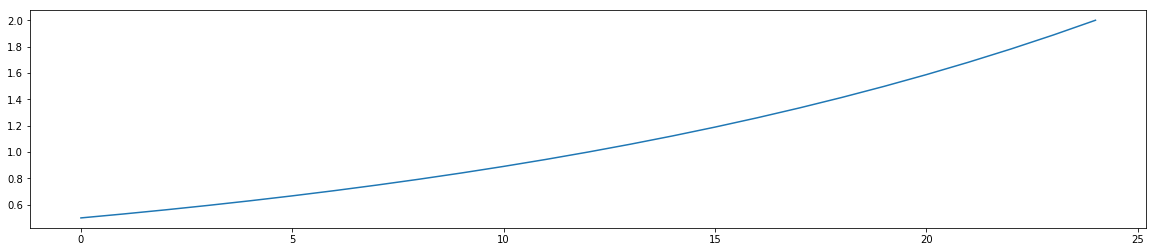

In [72]:
pitchMults = pow(2,arange(13)/12)
freqMuls = np.concatenate((0.5 * pitchMults, pitchMults[1:]))
figsize(20,4)
plot(freqMuls)

In [75]:
testAlgos = [bl_sawtooth, bl_square, bl_triangle]
testFreqs = [40,80,160,320,640, 1280, 2560]

In [ ]:
%%time

sr = 8000
testLen = 1024
windowSize = testLen


def evalModel(modelSize, lr, testPattern):
    params = {'N':modelSize, 'NetSR':1.5, 'NetinpScaling':1,'BiasScaling':0.5,'TychonovAlpha':0.001,
             'washoutLength':windowSize*1, 'learnLength':windowSize * 1, 'TychonovAlphaReadout':0.001,
              'LR': lr,
              'patts':testPattern
             }

    sampleSize = 1
    loadedNets = np.zeros(sampleSize, dtype=np.object)
    for i_net, net in enumerate(loadedNets):
        print(i_net)
        loadedNets[i_net] = makeLoadedNetwork_v2(params)
    nrmses = [x['NRMSE_W'] for x in loadedNets]
    bestNetwork = np.argmin(nrmses)
    print("NRMSEs: best: ", loadedNets[bestNetwork]['NRMSE_W'], "avg: ", np.mean(nrmses) )

    import scipy
    def fitnessf(aperture, *args):
#         print('Pattern: ', args[0])
        cnet = computeConceptor(params, loadedNets[bestNetwork], args[0], aperture)
        atten = testConceptor(params, cnet, windowSize)
        return atten

    #scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=0.1, args = (0,))
    apertures = [scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=1, args = (x,)) 
                 for x in np.arange(params['patts'].shape[0])]

    #store conceptors with calculated apertures
    patternCs = np.zeros(len(apertures), dtype=np.object)
    for i_patt in range(patternCs.size):
#         print(i_patt, " ", end='')
        patternCs[i_patt] = computeConceptor(params, loadedNets[bestNetwork], i_patt, apertures[i_patt])
#     print("Done")
    return patternCs
    
lrList = linspace(0.01,0.99,15)
rl = testLen

def testModel(modelSize, lr, testPat):
    model = evalModel(modelSize, lr, testPat)
    srCtl = ones(rl)
    lrCtl = ones(rl)
    numRenders = 5
    renderErrors = zeros(numRenders)
    for r in range(numRenders):
        audio = render(model, srCtl, lrCtl, rl=rl, oversample=1)
        renderErrors[r] = compareMelSpec(audio, testPat[0])
    print(renderErrors)
    error = median(renderErrors)
    return error, model

trials=5
def searchLRs(modelSize, testPat):
    bestError=999
    bestLR = 0
    bestModel = None
    for lr in lrList:
        print("LR: ", lr)
#         lrScores = zeros(trials)
        for t in range(trials):
            print("Trial: ", t)
            error, model = testModel(modelSize, lr, testPat)
#             lrScores[t] = error
            print("Trial error: ", error)
#         print("LR scores: ", lrScores)
#         medianError = np.median(lrScores)
#         print("median error: ", medianError)
            if (error < bestError):
                print("Best so far ***************** ")
                bestError = error
                bestLR = lr
                bestModel = model
            
    print("Best error: ", bestError, " best LR: ", bestLR)
    return bestLR, bestModel, bestError


def findBestModel(lr, testPat):
    print("Finding high res model: ", lr)
    bestModel = None
    bestError = 999
    for t in range(10):
        print("Trial: ", t)
        error, model = testModel(800, lr, testPat)
        print("Error: ", error)
        if (error < bestError):
            bestModel = model
            bestError = error
    print("Best high res error: ", bestError)
    return bestModel



def runOsc(freq, algo):
    t = linspace(0, (testLen/sr), num = testLen, endpoint = False)
    sig = algo(2 * pi * freq * t) * 0.5
    return sig

def testPitches(model, algo, testFreq, ):
    freqErrors = zeros_like(freqMuls)
    print(bestLR)
    srCtl = ones(rl)
    for i, freqMul in enumerate(freqMuls):
        if ((model[0]['net']['p']['LR'] * freqMul) <= 1):
            print("testing at ", testFreq * freqMul, " Hz")
            testSig = runOsc(testFreq * freqMul, algo)
            lrCtl = ones(rl) * freqMul
            numRenders = 5
            renderErrors = zeros(numRenders)
            for r in range(numRenders):
                renderSig = render(model, srCtl, lrCtl, rl=rl, oversample=1)
                renderErrors[r] = compareMelSpec(renderSig, testSig)
            error = np.min(renderErrors)
            print("Error: ",error)
            freqErrors[i] = error
        else:
            print("can't test, max lr")
            freqErrors[i] = -1
    return freqErrors


# testAlgos = [bl_sawtooth]
# testFreqs = [40]

allResults = zeros((len(testAlgos), len(testFreqs), len(freqMuls)))
allLRs = zeros((len(testAlgos), len(testFreqs)))


for i_algo, algo in enumerate(testAlgos):
    for i_testFreq, testFreq in enumerate(testFreqs):
        print("====== running test: ", testFreq, str(algo))
        testPattern = np.array([runOsc(testFreq, algo)])
        bestLR, bestModel, bestError = searchLRs(800, testPattern)
#         bestLR = 0.2
#         bestModel = findBestModel(bestLR, testPattern)
        freqErrors = testPitches(bestModel, bl_sawtooth, testFreq)
        allResults[i_algo][i_testFreq] = freqErrors
        allLRs[i_algo][i_testFreq] = bestLR
        import dill as pickle
        ts = str(datetime.datetime.timestamp(datetime.datetime.now()))
        with open(r"pitchResults/allres3_" + ts + ".pickled", "wb") as output_file:    
            pickle.dump({"res":allResults,"lrs":allLRs}, output_file, protocol=0)


    

====== running test:  40 <function bl_sawtooth at 0x7fc012258e18>
LR:  0.01
Trial:  0
0
Loading patterns: 0  
NRMSE readout:  0.33586244282768807  :: absSize readout:  1.017320151456425
NRMSE W:  0.06437871527726818  :: absSize W:  0.5162673498288932
NRMSEs: best:  0.06437871527726818 avg:  0.06437871527726818
 
 Func-count     x          f(x)          Procedure
    1        381.966  9.44643e-08        initial
    2        618.034  2.64958e-07        golden
    3        236.068  1.24298e-07        golden
    4        351.159  9.85595e-08        parabolic
    5        472.136  8.94057e-08        golden
    6        471.219  1.25224e-07        parabolic
    7        527.864  2.56669e-07        golden
    8        493.422  1.16016e-07        golden
    9        480.267  1.21499e-07        golden
   10        475.242  8.98853e-08        golden
   11        473.322  1.42617e-07        golden
   12        472.589  1.27877e-07        golden
   13        471.786  1.44934e-07        golden

Opt

Loading patterns: 0  
NRMSE readout:  0.08187779882578904  :: absSize readout:  0.349974309465539
NRMSE W:  0.027103975887337647  :: absSize W:  0.2674047003029042
NRMSEs: best:  0.027103975887337647 avg:  0.027103975887337647
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000158187        initial
    2        618.034  0.000341655        golden
    3        236.068  3.00868e-05        golden
    4        145.898  3.01813e-05        golden
    5        191.124  3.01518e-05        parabolic
    6        291.796  4.56759e-05        golden
    7        257.354  3.00788e-05        golden
    8        258.422  3.00469e-05        parabolic
    9         271.17  3.00961e-05        golden
   10        263.292  3.00519e-05        golden
   11         260.76   3.0063e-05        parabolic
   12        259.315  3.00697e-05        golden
   13        258.014  3.00807e-05        golden
   14        258.763  3.00667e-05        golden

Optimization terminated successfully;

Loading patterns: 0  
NRMSE readout:  0.034211765564864924  :: absSize readout:  0.20711204624446655
NRMSE W:  0.019098548333991647  :: absSize W:  0.2241962071523932
NRMSEs: best:  0.019098548333991647 avg:  0.019098548333991647
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00407576        initial
    2        618.034   0.00487161        golden
    3        236.068   0.00189924        golden
    4        145.898  0.000212367        golden
    5        90.1699  5.09627e-06        golden
    6         99.932   0.00181104        parabolic
    7        55.7281  5.91115e-06        golden
    8         73.234  5.18404e-06        parabolic
    9         84.157   0.00168058        parabolic
   10        90.5033  4.59328e-06        parabolic
   11        94.1047   0.00177217        golden
   12        91.8789   0.00175481        golden
   13        91.0287  4.82339e-06        golden

Optimization terminated successfully;
The returned value satisfies the terminat

   16        457.394   0.00629908        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[1.37600024 1.38024366 1.38024366 1.37793215 1.37785519]
Trial error:  1.37793214885354
Trial:  1
0
Loading patterns: 0  
NRMSE readout:  0.007763405784086909  :: absSize readout:  0.07332658718022292
NRMSE W:  0.014398106903630848  :: absSize W:  0.24017061829497346
NRMSEs: best:  0.014398106903630848 avg:  0.014398106903630848
 
 Func-count     x          f(x)          Procedure
    1        381.966     0.278371        initial
    2        618.034      0.38773        golden
    3        236.068   0.00218372        golden
    4        145.898    0.0022042        golden
    5        190.997   0.00243206        parabolic
    6        291.796  0.000213173        golden
    7        326.238  0.000220984        golden
    8         308.73  0.000223797        parabolic
    9         270.51   0.00146609        golden
   10        283.

 
 Func-count     x          f(x)          Procedure
    1        381.966     0.354832        initial
    2        618.034     0.399087        golden
    3        236.068   0.00333411        golden
    4        145.898   0.00117006        golden
    5        189.795   0.00251278        parabolic
    6        90.1699   0.00137174        golden
    7        123.304    0.0010731        parabolic
    8        125.614   0.00104768        parabolic
    9        131.757  0.000974498        parabolic
   10        137.158  0.000900841        golden
   11        140.497  0.000847558        golden
   12         142.56  0.000808276        golden
   13        143.835  0.000778296        golden
   14        144.623  0.000754173        golden
   15         145.11  0.000732931        golden
   16        145.443  0.000706492        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[1.36710396 1.36713674 1.36723043 1.36718657 1.3672441

    9        21.2862  0.000907227        golden
   10        39.5127  0.000992519        parabolic
   11        34.1085  0.000548435        parabolic
   12        29.2108  0.000261413        golden
   13        28.8775  0.000237556        parabolic
   14        25.9779  0.000584136        golden
   15          27.77   0.00046487        golden
   16        28.5442  0.000221375        parabolic
   17        28.2108  0.000208172        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[0.38246569 0.69073346 0.28553146 0.35254666 0.39167124]
Trial error:  0.38246568965711814
Trial:  4
0
Loading patterns: 0  
NRMSE readout:  0.001130226273252735  :: absSize readout:  0.020479396749055433
NRMSE W:  0.010214387871492838  :: absSize W:  0.20085441549077912
NRMSEs: best:  0.010214387871492838 avg:  0.010214387871492838
 
 Func-count     x          f(x)          Procedure
    1        381.966     0.381988        initial
    

 
 Func-count     x          f(x)          Procedure
    1        381.966     0.313146        initial
    2        618.034     0.326235        golden
    3        236.068     0.279284        golden
    4        145.898     0.107316        golden
    5        90.1699   0.00123014        golden
    6        55.7281   0.00142011        golden
    7        73.0793   0.00139261        parabolic
    8        111.456   0.00135204        golden
    9        93.5994   0.00141695        parabolic
   10        89.8366  0.000874833        parabolic
   11        83.4359    0.0012446        golden
   12        86.8093   0.00150192        parabolic
   13        89.5033   0.00106756        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[0.63224135 0.8825098  0.87570623 0.7654543  0.56604169]
Trial error:  0.7654543035685965
Trial:  1
0
Loading patterns: 0  
NRMSE readout:  0.00025395944106917874  :: absSize readout:  0.00789815

   16        79.6066   7.1863e-05        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[0.37817124 0.4016116  0.29957385 0.37336858 0.39226716]
Trial error:  0.3781712362862613
Trial:  2
0
Loading patterns: 0  
NRMSE readout:  0.00015062592226128407  :: absSize readout:  0.005772983218538807
NRMSE W:  0.007656712942339716  :: absSize W:  0.1136044831507527
NRMSEs: best:  0.007656712942339716 avg:  0.007656712942339716
 
 Func-count     x          f(x)          Procedure
    1        381.966     0.321834        initial
    2        618.034     0.329054        golden
    3        236.068     0.305568        golden
    4        145.898    0.0161384        golden
    5        90.1699   0.00278576        golden
    6        112.149   0.00263324        parabolic
    7        101.635   0.00233184        parabolic
    8        102.277   0.00236192        parabolic
    9        97.2555   0.00202315        golden
   10     

    6        944.272     0.214621        golden
    7        965.558       0.2142        golden
    8        978.714     0.213936        golden
    9        986.844     0.213775        golden
   10        991.869     0.213668        golden
   11        994.975     0.213606        golden
   12        996.894     0.213568        golden
   13        998.081     0.213545        golden
   14        998.814      0.21353        golden
   15        999.267     0.213521        golden
   16          999.6     0.213515        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[1.43612635 1.43612635 1.43612635 1.43612635 1.43612635]
Trial error:  1.4361263489690463
Trial:  4
0
Loading patterns: 0  
NRMSE readout:  0.00011022890563605853  :: absSize readout:  0.004488242060446978
NRMSE W:  0.00765390407357326  :: absSize W:  0.10714289446727947
NRMSEs: best:  0.00765390407357326 avg:  0.00765390407357326
 
 Func-count     x        

 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00192699        initial
    2        618.034   0.00352055        golden
    3        236.068   0.00282937        golden
    4        400.334     0.178744        parabolic
    5        326.238     0.163992        golden
    6         360.68   0.00362866        golden
    7        373.835   0.00262364        golden
    8        388.982     0.177491        golden
    9         378.86     0.176178        golden
   10        384.646   0.00303323        golden
   11         380.78     0.176447        golden
   12         382.99   0.00309434        golden
   13        381.513   0.00355314        golden
   14        382.357    0.0030386        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[0.41838267 0.76509642 1.40132204 0.49485292 1.40132204]
Trial error:  0.7650964177070954
Trial:  1
0
Loading patterns: 0  
NRMSE readout:  0.00010609404465791

 
 Func-count     x          f(x)          Procedure
    1        381.966    0.0167357        initial
    2        618.034    0.0147932        golden
    3        763.932       0.0128        golden
    4        854.102    0.0115735        golden
    5         909.83    0.0107713        golden
    6        944.272    0.0103121        golden
    7        965.558    0.0100381        golden
    8        978.714   0.00987653        golden
    9        986.844    0.0112517        golden
   10        973.689   0.00993968        golden
   11        981.819   0.00984264        golden
   12        983.739   0.00982233        golden
   13        984.925    0.0106197        golden
   14        983.006    0.0098305        golden
   15        984.192    0.0104217        golden
   16        983.405   0.00982636        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[1.28215683 1.28228811 1.18755128 1.28186052 1.23971131]
Trial err

   11        994.975   0.00494261        golden
   12        996.894   0.00493691        golden
   13        998.081   0.00493339        golden
   14        998.814   0.00493121        golden
   15        999.267   0.00492987        golden
   16          999.6   0.00492888        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[1.27895313 1.27895313 1.27895313 1.27895313 1.27895313]
Trial error:  1.2789531316165001
Trial:  4
0
Loading patterns: 0  
NRMSE readout:  0.0001938863679992289  :: absSize readout:  0.0037929257860598795
NRMSE W:  0.0021193902341672638  :: absSize W:  0.06869163008043752
NRMSEs: best:  0.0021193902341672638 avg:  0.0021193902341672638
 
 Func-count     x          f(x)          Procedure
    1        381.966    0.0141502        initial
    2        618.034    0.0334584        golden
    3        236.068    0.0992711        golden
    4        476.518    0.0145903        parabolic
    5       

[1.41892185 1.41919155 1.41924626 1.42066952 1.41966368]
Trial error:  1.419246264127903
Trial:  4
0
Loading patterns: 0  
NRMSE readout:  0.4306093512242736  :: absSize readout:  1.5649949913404395
NRMSE W:  0.08453758886892893  :: absSize W:  0.8101886980309934
NRMSEs: best:  0.08453758886892893 avg:  0.08453758886892893
 
 Func-count     x          f(x)          Procedure
    1        381.966  4.58685e-05        initial
    2        618.034  1.29969e-07        golden
    3        763.932  1.16451e-07        golden
    4        691.074  1.09137e-07        parabolic
    5         708.51  1.11209e-07        parabolic
    6        663.175  1.17763e-07        golden
    7        680.418  1.10092e-07        golden
    8        691.784  1.30202e-07        parabolic
    9        690.741  1.15343e-07        parabolic
   10        691.408  1.23577e-07        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[1.40909028 1.435

[1.43136495 1.43517033 1.43332138 1.43199855 1.4329247 ]
Trial error:  1.4329247020560139
Trial:  1
0
Loading patterns: 0  
NRMSE readout:  0.0470489723469373  :: absSize readout:  0.2859871424524547
NRMSE W:  0.026272658569096347  :: absSize W:  0.32128989636504934
NRMSEs: best:  0.026272658569096347 avg:  0.026272658569096347
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00284171        initial
    2        618.034   0.00265165        golden
    3        763.932    0.0028185        golden
    4        578.904    0.0026683        parabolic
    5         623.56    0.0026612        parabolic
    6        602.879   0.00272701        parabolic
    7        612.245   0.00267556        golden
    8        615.823   0.00260299        golden
    9        614.456   0.00265524        golden
   10        616.275   0.00254653        parabolic
   11        616.797   0.00261629        parabolic

Optimization terminated successfully;
The returned value satisfies the t

[0.2488505  0.40320982 0.25483124 0.38746522 0.35512895]
Trial error:  0.35512894549968144
Trial:  3
0
Loading patterns: 0  
NRMSE readout:  0.018086724481945496  :: absSize readout:  0.1441389690677803
NRMSE W:  0.01838550106330578  :: absSize W:  0.289410001190287
NRMSEs: best:  0.01838550106330578 avg:  0.01838550106330578
 
 Func-count     x          f(x)          Procedure
    1        381.966    0.0023221        initial
    2        618.034     0.242854        golden
    3        236.068   0.00212832        golden
    4        308.768   0.00225909        parabolic
    5        145.898   0.00181264        golden
    6        90.1699   0.00357033        golden
    7         180.34   0.00195771        golden
    8        124.612   0.00279046        golden
    9        159.054   0.00187222        golden
   10        137.767   0.00177266        golden
   11        132.742   0.00287685        golden
   12        140.873   0.00178825        golden
   13        135.848   0.00176281      

    6        291.796   0.00464209        golden
    7        326.238   0.00460845        golden
    8        313.547    0.0832929        parabolic
    9        326.571   0.00441005        parabolic
   10         347.73     0.145326        golden
   11        334.653     0.127845        golden
   12        329.658     0.119781        golden
   13         327.75     0.116425        golden
   14        327.022   0.00444668        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[1.43216716 1.43216716 1.43216716 1.43216716 1.31758122]
Trial error:  1.4321671579706465
LR:  0.36
Trial:  0
0
Loading patterns: 0  
NRMSE readout:  0.0027568918588291897  :: absSize readout:  0.035639113304049175
NRMSE W:  0.011153372251739537  :: absSize W:  0.2230610586637657
NRMSEs: best:  0.011153372251739537 avg:  0.011153372251739537
 
 Func-count     x          f(x)          Procedure
    1        381.966     0.322329        initial
    

    7         114.39  1.52413e-05        parabolic
    8        122.606  1.51563e-05        parabolic
    9        118.649  1.56817e-05        parabolic
   10         116.64   1.4227e-05        golden
   11        115.781  1.41159e-05        golden
   12        115.315  1.37522e-05        parabolic
   13        114.962  1.44207e-05        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[0.19787298 0.15215047 0.15632906 0.15523416 0.16502099]
Trial error:  0.15632906341454575
Best so far ***************** 
Trial:  2
0
Loading patterns: 0  
NRMSE readout:  0.0011418796318062939  :: absSize readout:  0.021588226351985904
NRMSE W:  0.007966419725701784  :: absSize W:  0.17568708767472793
NRMSEs: best:  0.007966419725701784 avg:  0.007966419725701784
 
 Func-count     x          f(x)          Procedure
    1        381.966     0.301923        initial
    2        618.034     0.336551        golden
    3        236.068   

    8        34.4419   0.00465381        golden
    9        21.2862   0.00421839        golden
   10        24.1685   0.00439197        parabolic
   11        13.1556    0.0035429        golden
   12        8.13062   0.00399144        golden
   13          14.05     0.003501        parabolic
   14         16.814   0.00374519        golden
   15        14.3833   0.00348747        parabolic
   16        15.3118   0.00350685        golden
   17        14.7167   0.00347755        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[1.43628528 1.4363237  1.43671301 1.43672937 1.4366125 ]
Trial error:  1.4366124987952342
Trial:  4
0
Loading patterns: 0  
NRMSE readout:  0.0006408750677976749  :: absSize readout:  0.014154169313828126
NRMSE W:  0.0071996447577767474  :: absSize W:  0.1450289843449084
NRMSEs: best:  0.0071996447577767474 avg:  0.0071996447577767474
 
 Func-count     x          f(x)          Procedure
    1 

Loading patterns: 0  
NRMSE readout:  0.0001543207416903176  :: absSize readout:  0.005707728724434046
NRMSE W:  0.005878120587693599  :: absSize W:  0.09872063229304649
NRMSEs: best:  0.005878120587693599 avg:  0.005878120587693599
 
 Func-count     x          f(x)          Procedure
    1        381.966     0.260427        initial
    2        618.034     0.272069        golden
    3        236.068     0.235117        golden
    4        145.898     0.180193        golden
    5        90.1699    0.0268116        golden
    6        55.7281    0.0211859        golden
    7        70.1046   0.00203665        parabolic
    8        71.8531    0.0249169        parabolic
    9        63.6612    0.0233657        parabolic
   10        67.6434    0.0241923        golden
   11        69.1645    0.0244704        golden
   12        70.7725     0.024744        golden
   13        69.7455    0.0245716        golden
   14        70.4379    0.0246887        golden

Optimization terminated success

   14        134.285   0.00216618        golden
   15        135.839   0.00213977        golden
   16        136.206   0.00213206        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[1.42491354 1.42491711 1.42491354 1.42491355 1.42491352]
Trial error:  1.4249135381981144
Trial:  2
0
Loading patterns: 0  
NRMSE readout:  0.00017532481263965054  :: absSize readout:  0.005054131143415497
NRMSE W:  0.005108501252253612  :: absSize W:  0.07324304630726924
NRMSEs: best:  0.005108501252253612 avg:  0.005108501252253612
 
 Func-count     x          f(x)          Procedure
    1        381.966     0.168299        initial
    2        618.034      0.17056        golden
    3        236.068    0.0320061        golden
    4        145.898    0.0112639        golden
    5        152.422   0.00888582        parabolic
    6        174.801    0.0142746        parabolic
    7         160.97    0.0162732        golden
    8       

   10        13.1556   0.00106653        golden
   11         21.937  0.000315406        parabolic
   12         25.192    0.0002105        parabolic
   13        28.7251   0.00120268        golden
   14        26.5415  0.000199884        golden
   15        26.8749   0.00021015        parabolic
   16         26.038  0.000209181        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[0.32627843 0.33138193 0.36919661 0.32321852 0.34364024]
Trial error:  0.33138192980333186
Trial:  4
0
Loading patterns: 0  
NRMSE readout:  0.00017497622716709836  :: absSize readout:  0.004296611348986786
NRMSE W:  0.0055909885681050125  :: absSize W:  0.0827066023602396
NRMSEs: best:  0.0055909885681050125 avg:  0.0055909885681050125
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00606595        initial
    2        618.034   0.00506349        golden
    3        763.932   0.00351036        golden
   

 
 Func-count     x          f(x)          Procedure
    1        381.966    0.0424788        initial
    2        618.034    0.0318553        golden
    3        763.932    0.0271913        golden
    4        854.102    0.0248062        golden
    5         909.83    0.0234837        golden
    6        944.272    0.0227172        golden
    7        965.558    0.0222615        golden
    8        978.714    0.0219865        golden
    9        986.844     0.021819        golden
   10        991.869    0.0217173        golden
   11        994.975    0.0216542        golden
   12        996.894    0.0216144        golden
   13        998.081    0.0215914        golden
   14        998.814    0.0215766        golden
   15        999.267    0.0215666        golden
   16          999.6    0.0215608        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[1.43548114 1.43548114 1.43548114 1.43548114 1.43548114]
Trial err

[1.41555121 1.41558801 1.41558801 1.41557257 1.41558785]
Trial error:  1.4155878484637903
Trial:  2
0
Loading patterns: 0  
NRMSE readout:  0.0006385697819591926  :: absSize readout:  0.00527867322832582
NRMSE W:  0.004037906547886235  :: absSize W:  0.06010756866547085
NRMSEs: best:  0.004037906547886235 avg:  0.004037906547886235
 
 Func-count     x          f(x)          Procedure
    1        381.966     0.007597        initial
    2        618.034    0.0132906        golden
    3        236.068    0.0051166        golden
    4        145.898   0.00506934        golden
    5        187.228   0.00517549        parabolic
    6        90.1699   0.00347539        golden
    7        55.7281   0.00202017        golden
    8        34.4419    0.0024495        golden
    9        54.0884   0.00220888        parabolic
   10        68.8837   0.00239582        golden
   11        60.8354    0.0021934        parabolic
   12        57.5138    0.0022131        parabolic
   13        56.4102    

    8        55.7281  4.25746e-08        golden
    9        34.4419  4.50101e-08        golden
   10        68.8837  4.35736e-08        golden
   11        47.5975  4.36478e-08        golden
   12        60.7531  4.26936e-08        golden
   13        52.6225  4.28286e-08        golden
   14        57.3276  4.22305e-08        parabolic
   15        58.0707  4.32927e-08        parabolic
   16        56.7167  4.28243e-08        golden
   17         57.661  4.32987e-08        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[1.44268346 1.4426719  1.44269053 1.44268432 1.44268646]
Trial error:  1.4426843213842393
Trial:  3
0
Loading patterns: 0  
NRMSE readout:  0.5387965482825227  :: absSize readout:  1.2018231902360328
NRMSE W:  0.09679609573996759  :: absSize W:  0.6331501854410962
NRMSEs: best:  0.09679609573996759 avg:  0.09679609573996759
 
 Func-count     x          f(x)          Procedure
    1        381.966  6

 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000506242        initial
    2        618.034  0.000747592        golden
    3        236.068   0.00036388        golden
    4        145.898  0.000704691        golden
    5        284.798  0.000187609        parabolic
    6        298.696  0.000275911        parabolic
    7        271.793  0.000192176        parabolic
    8            279  0.000190417        parabolic
    9        290.106  0.000232893        golden
   10        282.583  0.000207474        golden
   11        286.825  0.000205232        golden
   12        283.952  0.000185532        golden
   13        283.429  0.000191532        golden
   14        284.285  0.000204521        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[1.4347331  1.43329135 1.42966307 1.42535104 1.43469195]
Trial error:  1.4332913511988699
LR:  0.15
Trial:  0
0
Loading patterns: 0  
NRMSE readout:  

[1.36370318 1.10212168 1.09823689 1.38826577 1.41607119]
Trial error:  1.3637031808103357
Best so far ***************** 
Trial:  1
0
Loading patterns: 0  
NRMSE readout:  0.01994341184356617  :: absSize readout:  0.15686754467967326
NRMSE W:  0.01804826340978001  :: absSize W:  0.31351108501250474
NRMSEs: best:  0.01804826340978001 avg:  0.01804826340978001
 
 Func-count     x          f(x)          Procedure
    1        381.966     0.446434        initial
    2        618.034     0.486321        golden
    3        236.068  0.000847976        golden
    4        145.898   0.00093079        golden
    5        191.018   0.00104023        parabolic
    6        291.796     0.363566        golden
    7        257.354     0.258795        golden
    8        218.861  0.000932858        golden
    9        244.199     0.169488        golden
   10        229.495  0.000879319        golden
   11        239.174  0.000833893        golden
   12        241.093  0.000823948        golden
   13  

    4        145.898   0.00118588        golden
    5        90.1699  0.000384012        golden
    6        117.616  0.000516834        parabolic
    7        96.7268  0.000526808        parabolic
    8        55.7281  6.93296e-05        golden
    9        34.4419  0.000152461        golden
   10        53.4288   7.0152e-05        parabolic
   11        55.3948  6.82927e-05        parabolic
   12        54.6798   6.9997e-05        parabolic
   13        55.0614   7.0122e-05        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[0.52261871 0.54052778 0.97053995 1.04092995 1.09664164]
Trial error:  0.9705399484751636
Best so far ***************** 
Trial:  3
0
Loading patterns: 0  
NRMSE readout:  0.006781495257780319  :: absSize readout:  0.07164623200946918
NRMSE W:  0.015697035544009783  :: absSize W:  0.24943479008375577
NRMSEs: best:  0.015697035544009783 avg:  0.015697035544009783
 
 Func-count     x          

 
 Func-count     x          f(x)          Procedure
    1        381.966     0.428119        initial
    2        618.034     0.438945        golden
    3        236.068     0.390694        golden
    4        145.898    0.0051281        golden
    5        90.1699   0.00544795        golden
    6        118.132   0.00526469        parabolic
    7         180.34     0.330854        golden
    8        159.054     0.217357        golden
    9        135.292   0.00517499        golden
   10        150.923   0.00510798        golden
   11        154.029   0.00509618        golden
   12        155.948   0.00508913        golden
   13        157.134   0.00508486        golden
   14        157.867     0.188235        golden
   15        156.681   0.00508649        golden
   16        157.468   0.00508368        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[1.43319087 1.43319087 1.43319087 1.43319087 1.43319087]
Trial 

    6        117.867  0.000585724        parabolic
    7        111.961  0.000718243        parabolic
    8        128.574   0.00105964        golden
    9        121.957  0.000857298        golden
   10        115.611  0.000430876        golden
   11        115.278  0.000882344        parabolic
   12        115.945  0.000762079        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[0.77116311 0.29317252 0.75582236 1.05398564 0.56720688]
Trial error:  0.7558223636680551
Trial:  1
0
Loading patterns: 0  
NRMSE readout:  0.0009018058160882241  :: absSize readout:  0.013457245906262077
NRMSE W:  0.009005993532385532  :: absSize W:  0.1937320165466111
NRMSEs: best:  0.009005993532385532 avg:  0.009005993532385532
 
 Func-count     x          f(x)          Procedure
    1        381.966     0.208382        initial
    2        618.034     0.199475        golden
    3        763.932     0.193008        golden
    4   

    2        618.034     0.338327        golden
    3        236.068     0.306267        golden
    4        145.898     0.245212        golden
    5        90.1699   0.00306108        golden
    6        55.7281   0.00336988        golden
    7        73.0419   0.00186549        parabolic
    8        73.9344   0.00303395        parabolic
    9        66.4286   0.00276232        golden
   10        70.0875    0.0033029        parabolic
   11        72.7085   0.00297157        parabolic
   12        73.3828   0.00276556        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[1.36006013 1.33135991 1.3162352  1.36665611 1.3497312 ]
Trial error:  1.3497311959128697
Trial:  3
0
Loading patterns: 0  
NRMSE readout:  0.00026921856029260674  :: absSize readout:  0.007455033431874814
NRMSE W:  0.010137108106275926  :: absSize W:  0.1197897576332555
NRMSEs: best:  0.010137108106275926 avg:  0.010137108106275926
 
 Func-count

Loading patterns: 0  
NRMSE readout:  0.00016735230713895918  :: absSize readout:  0.0051583776425290565
NRMSE W:  0.00957661441959672  :: absSize W:  0.1256464152317106
NRMSEs: best:  0.00957661441959672 avg:  0.00957661441959672
 
 Func-count     x          f(x)          Procedure
    1        381.966    0.0126999        initial
    2        618.034   0.00991286        golden
    3        763.932    0.0105704        golden
    4        638.219   0.00821786        parabolic
    5        687.781    0.0110266        parabolic
    6         657.15   0.00915355        golden
    7        640.438   0.00914617        parabolic
    8        630.509    0.0110749        golden
    9        635.274   0.00920591        golden
   10        637.094   0.00984139        golden
   11        639.066    0.0100931        golden
   12        637.789   0.00887855        golden
   13        638.552   0.00798964        golden

Optimization terminated successfully;
The returned value satisfies the terminatio

   15        198.247   0.00238629        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[0.34821017 0.67998837 0.51600202 0.39568011 0.70054742]
Trial error:  0.5160020163845417
Trial:  1
0
Loading patterns: 0  
NRMSE readout:  0.00015101209443348345  :: absSize readout:  0.004020109057604318
NRMSE W:  0.008945669278045246  :: absSize W:  0.12036003349877823
NRMSEs: best:  0.008945669278045246 avg:  0.008945669278045246
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00326273        initial
    2        618.034   0.00197308        golden
    3        763.932    0.0021956        golden
    4        649.302   0.00185543        parabolic
    5        674.452   0.00184498        parabolic
    6        665.381   0.00208658        parabolic
    7        674.785   0.00194049        parabolic
    8        670.987   0.00195471        golden
    9        673.128   0.00194666        golden
   10 

[1.30088477 1.18392311 1.26440451 0.89555014 1.19624954]
Trial error:  1.19624953647514
Trial:  3
0
Loading patterns: 0  
NRMSE readout:  8.056342295856575e-05  :: absSize readout:  0.00346953485292474
NRMSE W:  0.007321930954486217  :: absSize W:  0.12710562473511897
NRMSEs: best:  0.007321930954486217 avg:  0.007321930954486217
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00844517        initial
    2        618.034    0.0704853        golden
    3        236.068   0.00504124        golden
    4        290.411   0.00565787        parabolic
    5        219.893   0.00602366        parabolic
    6        257.689   0.00740634        parabolic
    7        244.327    0.0062073        golden
    8         229.89   0.00511679        golden
    9        239.222   0.00646159        golden
   10        233.708    0.0059765        golden
   11        237.273   0.00508842        golden
   12        235.167   0.00423968        golden
   13         234.61   0.0045

   12        937.392   0.00641557        golden
   13        937.894   0.00641068        golden
   14        938.228   0.00647827        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[1.43386607 1.43499507 1.43525563 1.43545628 1.43494089]
Trial error:  1.4349950737642483
LR:  0.99
Trial:  0
0
Loading patterns: 0  
NRMSE readout:  5.603897223840835e-05  :: absSize readout:  0.0029441624842658993
NRMSE W:  0.0070199692557288565  :: absSize W:  0.11618009890029089
NRMSEs: best:  0.0070199692557288565 avg:  0.0070199692557288565
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00708559        initial
    2        618.034   0.00165483        golden
    3        763.932    0.0193042        golden
    4        530.516   0.00168091        parabolic
    5         575.25   0.00164409        parabolic
    6        586.417   0.00164404        parabolic
    7         581.15    0.0016437        par

    4        372.032  2.19766e-07        parabolic
    5        472.136  2.72803e-07        golden
    6        416.408   2.2627e-07        golden
    7        395.122  1.83591e-07        golden
    8        375.951  2.54683e-07        parabolic
    9        382.299  2.40081e-07        parabolic
   10        379.668  2.43141e-07        golden
   11        381.088  2.05488e-07        golden
   12        381.631  2.68312e-07        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
[1.43821233 1.43798277 1.43773536 1.43794535 1.43787436]
Trial error:  1.4379453496737788
Best so far ***************** 
Trial:  1
0
Loading patterns: 0  
NRMSE readout:  0.539466250988668  :: absSize readout:  1.39232064259841
NRMSE W:  0.10283482247293489  :: absSize W:  0.707347926399247
NRMSEs: best:  0.10283482247293489 avg:  0.10283482247293489
 
 Func-count     x          f(x)          Procedure
    1        381.966  5.62931e-07        

###### 

In [73]:
with open(r"pitchResults/allres3_1558012449.162566.pickled", "rb") as infile:    
    data3 = pickle.load(infile)



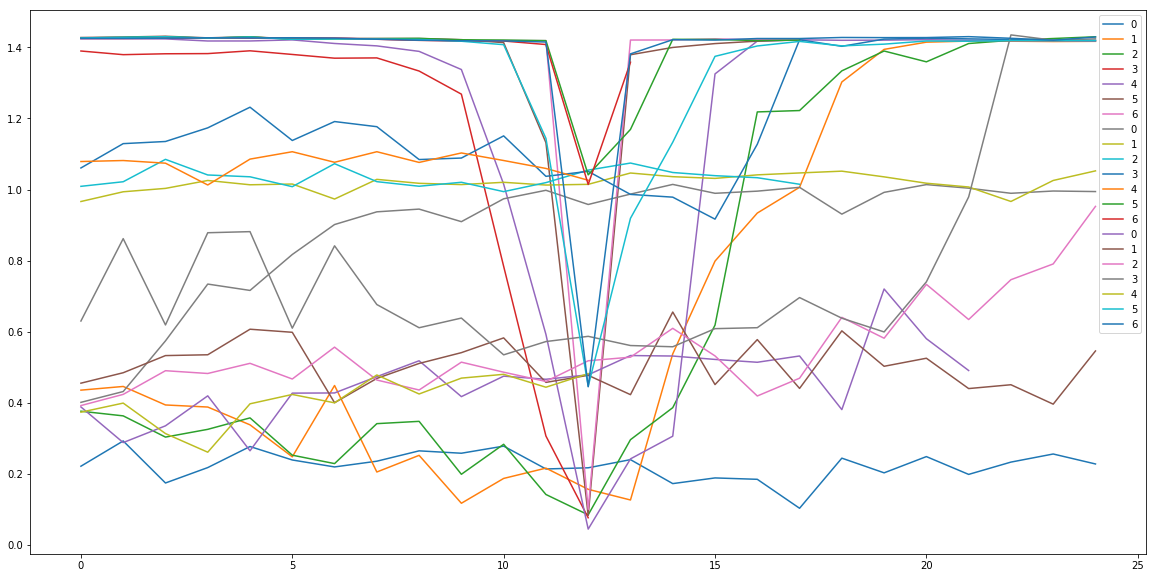

In [74]:
figsize(20,10)
for waveform in range(3):
    for i, series in enumerate(data3['res'][waveform]):
        y = array([q for q in series if q != -1])
        x = arange(y.shape[0])
        plot(y, label=str(i))
        
plt.legend()

In [137]:
def convToNan(x):
    return NaN if x == -1 else x

convToNan(0)


0

In [78]:
d = data3['res']

In [138]:
d = np.vectorize(convToNan)(d)

In [139]:
d.shape

(3, 7, 25)

In [140]:
d

array([[[0.22121765, 0.29232345, 0.17399711, 0.21736399, 0.276613  ,
         0.23875434, 0.21919012, 0.23532389, 0.26443695, 0.25774564,
         0.27774709, 0.2134662 , 0.21673469, 0.23970292, 0.17226822,
         0.18824091, 0.18435284, 0.10285945, 0.24388872, 0.20256012,
         0.24827738, 0.19816031, 0.23277503, 0.25558244, 0.22752959],
        [0.43531255, 0.44569943, 0.39360984, 0.38777488, 0.33764094,
         0.24763352, 0.44841559, 0.204921  , 0.25179328, 0.11696491,
         0.18682036, 0.21582843, 0.15617327, 0.1261417 , 0.53741724,
         0.79849725, 0.9336975 , 1.00630281, 1.30271975, 1.39443275,
         1.41474721, 1.41776596, 1.41739457, 1.41651521, 1.41711437],
        [0.37602095, 0.36290325, 0.30317141, 0.32499024, 0.35720412,
         0.25227559, 0.22855752, 0.34101204, 0.34747624, 0.19850777,
         0.28293092, 0.14163058, 0.08434794, 0.29586146, 0.38599228,
         0.61829921, 1.21839366, 1.22229134, 1.3339901 , 1.38983671,
         1.35938442, 1.41090339,

In [81]:
import seaborn as sns; sns.set(color_codes=True)

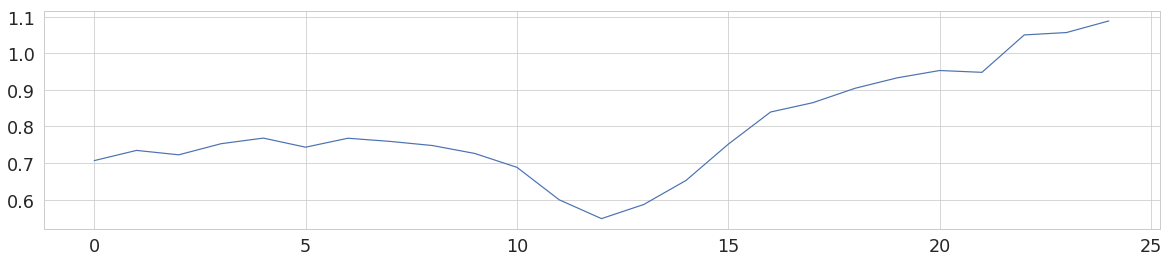

In [506]:
plot(avgAll)


In [507]:
testpitches =arange(-12,13)

In [234]:
import pandas as pd


In [426]:
df = pd.DataFrame(columns=["Waveform", "Frequency", "Relative Pitch", "Reconstruction Error"])

In [472]:
idx=0
for i_freq, freq in enumerate(testFreqs[:5]):
    print(freq)
    for i_note, note in enumerate(arange(-12,13)):
        df.loc[idx] = ["Saw",freq,note,d[0, i_freq, i_note]]
        idx = idx+1
for i_freq, freq in enumerate(testFreqs[:5]):
    print(freq)
    for i_note, note in enumerate(arange(-12,13)):
        df.loc[idx] = ["Square",freq,note,d[1, i_freq, i_note]]
        idx = idx+1
for i_freq, freq in enumerate(testFreqs[:5]):
    print(freq)
    for i_note, note in enumerate(arange(-12,13)):
        df.loc[idx] = ["Triangle",freq,note,d[2, i_freq, i_note]]
        idx = idx+1
            

40
80
160
320
640
40
80
160
320
640
40
80
160
320
640


In [525]:
df

,Waveform,Frequency,Relative Pitch,Reconstruction Error
0,Saw,40,-12,0.221218
1,Saw,40,-11,0.292323
2,Saw,40,-10,0.173997
3,Saw,40,-9,0.217364
4,Saw,40,-8,0.276613
5,Saw,40,-7,0.238754
6,Saw,40,-6,0.219190
7,Saw,40,-5,0.235324
8,Saw,40,-4,0.264437
9,Saw,40,-3,0.257746


In [439]:
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=2)  

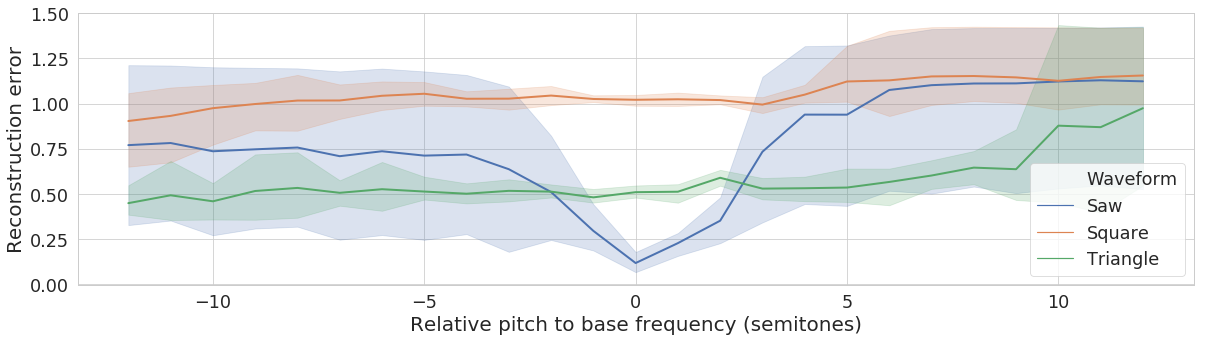

In [480]:
figsize(20,5)
sns.lineplot(x='Relative Pitch', y='Reconstruction Error', hue="Waveform", data=df, lw=2)
xlabel("Relative pitch to base frequency (semitones)", fontsize=20)
ylabel("Reconstruction error", fontsize=20)
plt.savefig("tmp/reconPitchSemis.pdf", bbox_inches='tight')

In [469]:
df2 = pd.DataFrame(columns=["Waveform", "Base Frequency", "note", "Reconstruction Error"])
idx=0
for i_wave, wave in enumerate(["Saw", "Square", "Triangle"]):
    print(wave)
    for i_freq, freq in enumerate(testFreqs):
        print(freq)
        for i_note, note in enumerate(arange(-12,13)):
            if (freq * freqMuls[i_note]) < sr/2:
                df2.loc[idx] = [wave,freq,note,d[i_wave, i_freq, i_note]]
            else:
                print("excluding freq: ", freq * freqMuls[i_note])
            
            idx = idx+1
    

Saw
40
80
160
320
640
1280
2560
excluding freq:  4063.7466930385904
excluding freq:  4305.389646099018
excluding freq:  4561.401436878537
excluding freq:  4832.63648093027
excluding freq:  5120.0
Square
40
80
160
320
640
1280
2560
excluding freq:  4063.7466930385904
excluding freq:  4305.389646099018
excluding freq:  4561.401436878537
excluding freq:  4832.63648093027
excluding freq:  5120.0
Triangle
40
80
160
320
640
1280
2560
excluding freq:  4063.7466930385904
excluding freq:  4305.389646099018
excluding freq:  4561.401436878537
excluding freq:  4832.63648093027
excluding freq:  5120.0


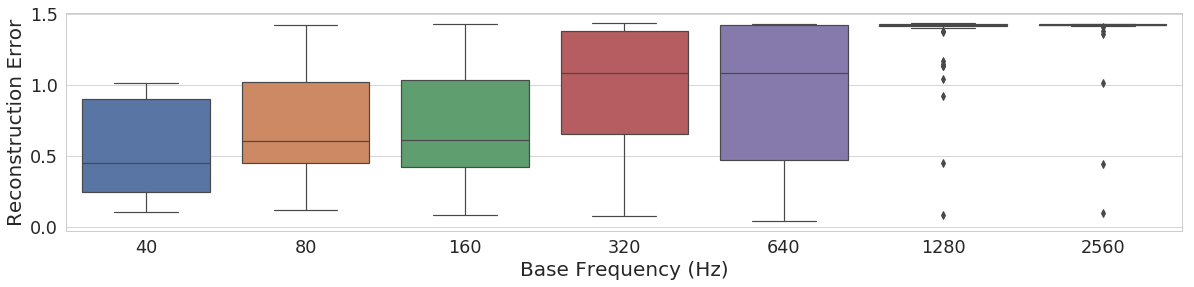

In [481]:
figsize(20,4)
sns.boxplot(x='Base Frequency', y='Reconstruction Error',data=df2)
xlabel("Base Frequency (Hz)", fontsize=20)
ylabel("Reconstruction Error", fontsize=20)
plt.savefig("tmp/pitchReconFreq.pdf", bbox_inches='tight')

In [535]:
dPitchRecon = df[["Relative Pitch", "Reconstruction Error"]]

In [595]:
posPitches = dPitchRecon.loc[dPitchRecon["Relative Pitch"] >= 0]

posPitches = posPitches.loc[posPitches["Reconstruction Error"] < 1000000] #remove NaNs

posPitches = array(posPitches)

In [596]:
posPitches

array([[ 0.        ,  0.21673469],
       [ 1.        ,  0.23970292],
       [ 2.        ,  0.17226822],
       [ 3.        ,  0.18824091],
       [ 4.        ,  0.18435284],
       [ 5.        ,  0.10285945],
       [ 6.        ,  0.24388872],
       [ 7.        ,  0.20256012],
       [ 8.        ,  0.24827738],
       [ 9.        ,  0.19816031],
       [10.        ,  0.23277503],
       [11.        ,  0.25558244],
       [12.        ,  0.22752959],
       [ 0.        ,  0.15617327],
       [ 1.        ,  0.1261417 ],
       [ 2.        ,  0.53741724],
       [ 3.        ,  0.79849725],
       [ 4.        ,  0.9336975 ],
       [ 5.        ,  1.00630281],
       [ 6.        ,  1.30271975],
       [ 7.        ,  1.39443275],
       [ 8.        ,  1.41474721],
       [ 9.        ,  1.41776596],
       [10.        ,  1.41739457],
       [11.        ,  1.41651521],
       [12.        ,  1.41711437],
       [ 0.        ,  0.08434794],
       [ 1.        ,  0.29586146],
       [ 2.        ,

In [597]:
scipy.stats.shapiro(posPitches[:,1])

(0.9247173070907593, 4.6683669552294305e-07)

In [598]:
scipy.stats.pearsonr(posPitches[:,0], posPitches[:,1])

(0.40299105085353515, 3.4789529018220155e-07)

In [580]:
negPitches = dPitchRecon.loc[dPitchRecon["Relative Pitch"] <= 0]

negPitches = negPitches.loc[negPitches["Reconstruction Error"] < 1000000] #remove NaNs

negPitches = array(negPitches)

In [581]:
negPitches

array([[-12.        ,   0.22121765],
       [-11.        ,   0.29232345],
       [-10.        ,   0.17399711],
       [ -9.        ,   0.21736399],
       [ -8.        ,   0.276613  ],
       [ -7.        ,   0.23875434],
       [ -6.        ,   0.21919012],
       [ -5.        ,   0.23532389],
       [ -4.        ,   0.26443695],
       [ -3.        ,   0.25774564],
       [ -2.        ,   0.27774709],
       [ -1.        ,   0.2134662 ],
       [  0.        ,   0.21673469],
       [-12.        ,   0.43531255],
       [-11.        ,   0.44569943],
       [-10.        ,   0.39360984],
       [ -9.        ,   0.38777488],
       [ -8.        ,   0.33764094],
       [ -7.        ,   0.24763352],
       [ -6.        ,   0.44841559],
       [ -5.        ,   0.204921  ],
       [ -4.        ,   0.25179328],
       [ -3.        ,   0.11696491],
       [ -2.        ,   0.18682036],
       [ -1.        ,   0.21582843],
       [  0.        ,   0.15617327],
       [-12.        ,   0.37602095],
 

In [585]:
scipy.stats.pearsonr(negPitches[:,0], negPitches[:,1])

(-0.09919697879754835, 0.16767597953597702)